In [1]:
import pandas as pd 
from pandas import Series
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.api import qqplot  
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import datasets

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
#Importing data
Beijing = pd.read_csv("/Users/kayinho/Downloads/FiveCitiePMData/BeijingPM20100101_20151231.csv")

In [3]:
#Delet non-useful data
Beijing.drop(['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'season', 'precipitation', 'Iprec'], 
               axis=1,
              inplace=True)

In [4]:
Beijing.dropna(axis=0, how="any",inplace=True)

In [5]:
# from datetime import datetime
Beijing['Time'] = pd.to_datetime(Beijing['year'].map(str) +"/"+ Beijing['month'].map(str) +"/"+ Beijing['day'].map(str)+" "+Beijing['hour'].map(str)+":00:00")
#Beijing

In [6]:
#Beijing.groupby(['year']).size()

In [7]:
by_hour = Beijing.groupby(['Time']).mean()
#print(by_hour.head())

In [8]:
by_hour.index = pd.to_datetime(by_hour.index, 
                             format='%d-%m-%Y %H:%M:%S')
by_hour = by_hour.set_index(by_hour.index).asfreq('H')
by_hour = by_hour.fillna(method='ffill')

#print(by_hour.index)

In [9]:
by_hour['Time'] = by_hour.index
#by_hour['Time']

In [10]:
data_13 = by_hour[(by_hour['Time'] >=pd.to_datetime('20130101030000')) & (by_hour['Time'] <= pd.to_datetime('20150101030000'))]

In [11]:
data_13 = data_13.set_index(data_13.index).asfreq('d')
#data_13

In [12]:
#by_hour

In [13]:
data = by_hour[(by_hour['Time'] >=pd.to_datetime('20130101030000')) & (by_hour['Time'] <= pd.to_datetime('20130112030000'))]
data = data.set_index(data.index).asfreq('H')
#data

In [14]:
split_result = seasonal_decompose(data['PM_US Post'],  
                            model ='multiplicative') 
  
# ETS plot  
#split_result.plot();

In [15]:
#len(data_13)

In [39]:
# Split data into train / test sets 
dataset = data_13[['PM_US Post','DEWP', 'TEMP', 'PRES', 'Iws', 'HUMI']]
train = dataset[:len(dataset)-156] 
test = dataset[len(dataset)-156:]

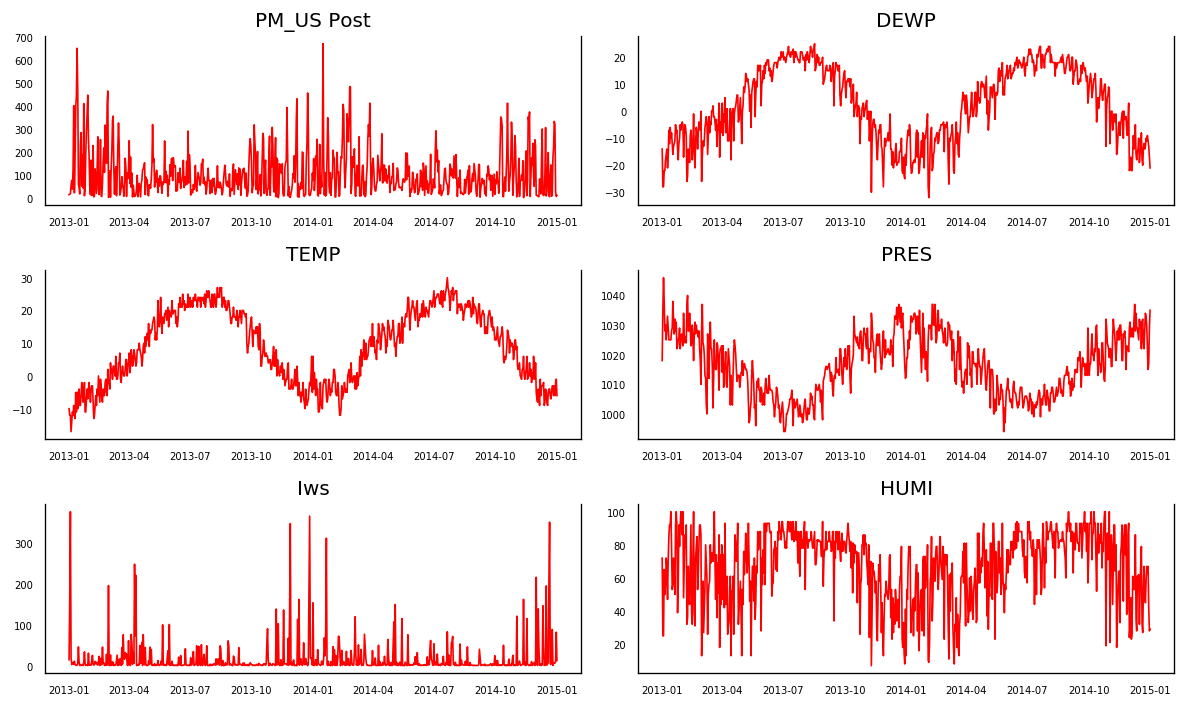

In [17]:
#preliminary plots of each variable
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = dataset[dataset.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(dataset.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

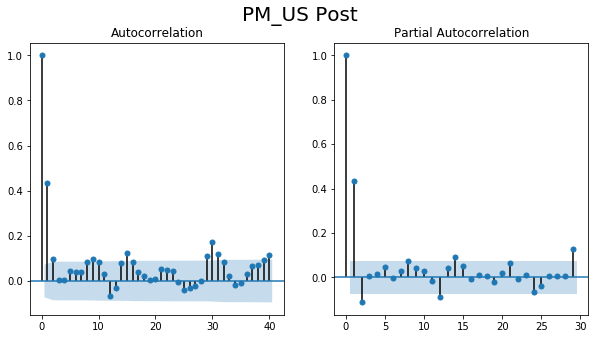

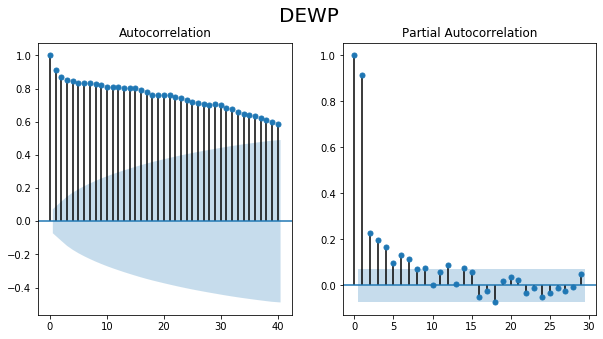

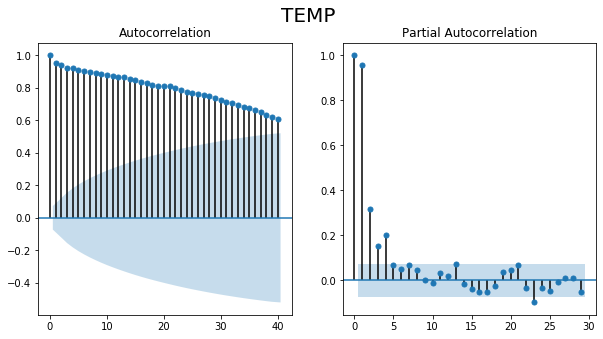

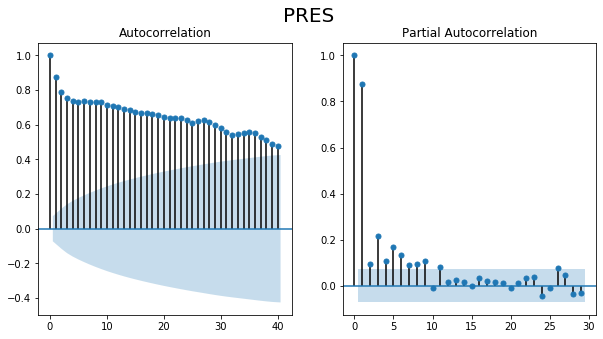

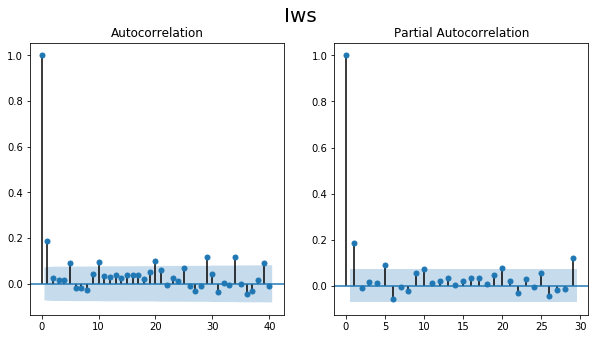

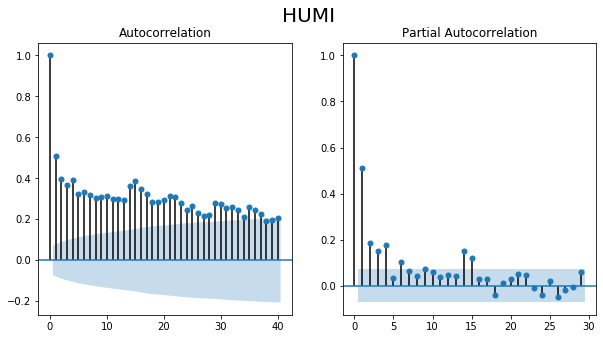

In [18]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('PM_US Post', fontsize=20)
ax[0] = plot_acf(dataset['PM_US Post'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['PM_US Post'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('DEWP', fontsize=20)
ax[0] = plot_acf(dataset['DEWP'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['DEWP'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('TEMP', fontsize=20)
ax[0] = plot_acf(dataset['TEMP'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['TEMP'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('PRES', fontsize=20)
ax[0] = plot_acf(dataset['PRES'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['PRES'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('Iws', fontsize=20)
ax[0] = plot_acf(dataset['Iws'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['Iws'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('HUMI', fontsize=20)
ax[0] = plot_acf(dataset['HUMI'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['HUMI'], ax = ax[1])

In [19]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(dataset, variables = dataset.columns)     

,PM_US Post_x,DEWP_x,TEMP_x,PRES_x,Iws_x,HUMI_x
PM_US Post_y,1.0000,0.0000,0.0000,0.0000,0.0112,0.0198
DEWP_y,0.0000,1.0000,0.0000,0.0000,0.0002,0.0000
TEMP_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
PRES_y,0.0000,0.0000,0.0000,1.0000,0.0007,0.0879
Iws_y,0.0012,0.0002,0.0001,0.0004,1.0000,0.0053
HUMI_y,0.0000,0.0000,0.0000,0.0000,0.0043,1.0000


In [20]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(dataset)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
PM_US Post ::  395.97    > 83.9383   =>   True
DEWP   ::  264.12    > 60.0627   =>   True
TEMP   ::  146.45    > 40.1749   =>   True
PRES   ::  46.63     > 24.2761   =>   True
Iws    ::  3.57      > 12.3212   =>   False
HUMI   ::  0.0       > 4.1296    =>   False


In [21]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
          
# ADF Test on each column
for name, column in train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PM_US Post" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.721
 No. Lags Chosen       = 1
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "DEWP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.1952
 No. Lags Chosen       = 11
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.6757. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "TEMP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.

In [22]:
train_diff = train.diff().dropna()

In [23]:
for name, column in train_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PM_US Post" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.9898
 No. Lags Chosen       = 13
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "DEWP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.5454
 No. Lags Chosen       = 10
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "TEMP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   

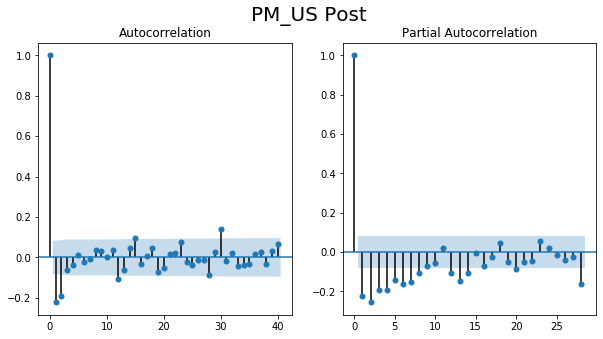

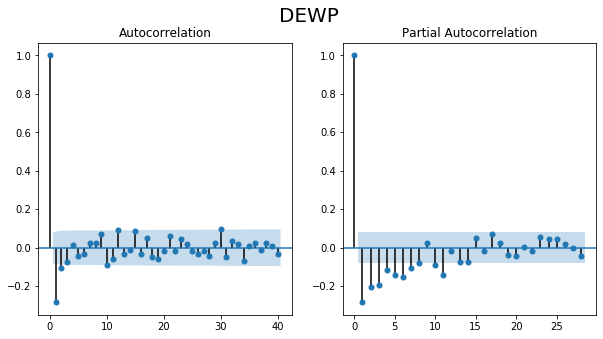

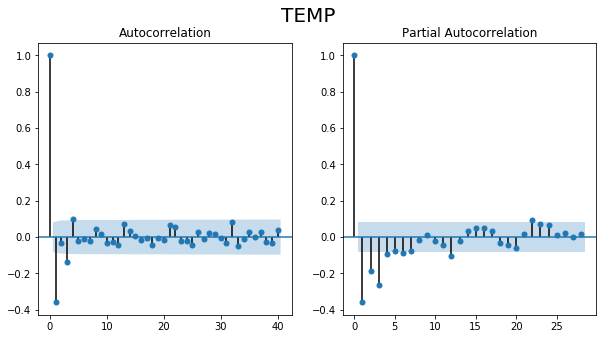

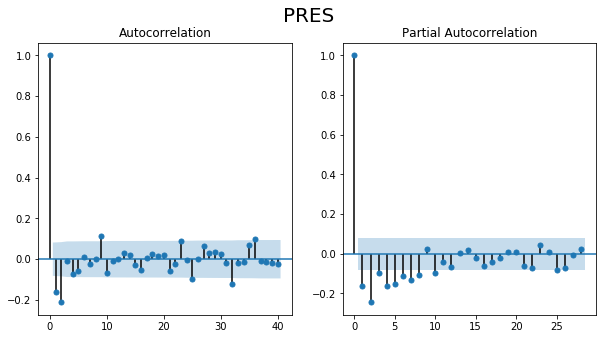

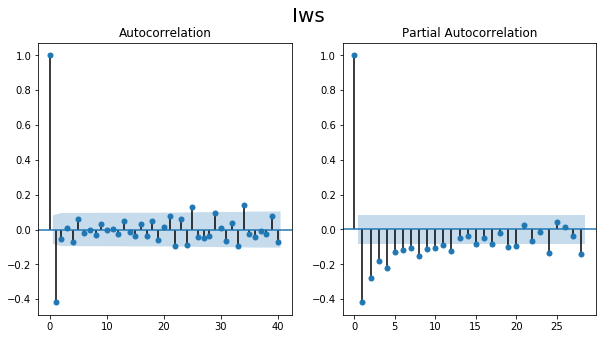

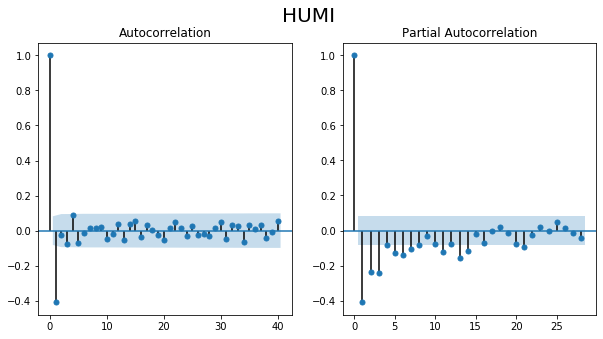

In [24]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('PM_US Post', fontsize=20)
ax[0] = plot_acf(train_diff['PM_US Post'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(train_diff['PM_US Post'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('DEWP', fontsize=20)
ax[0] = plot_acf(train_diff['DEWP'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(train_diff['DEWP'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('TEMP', fontsize=20)
ax[0] = plot_acf(train_diff['TEMP'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(train_diff['TEMP'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('PRES', fontsize=20)
ax[0] = plot_acf(train_diff['PRES'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(train_diff['PRES'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('Iws', fontsize=20)
ax[0] = plot_acf(train_diff['Iws'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(train_diff['Iws'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('HUMI', fontsize=20)
ax[0] = plot_acf(train_diff['HUMI'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(train_diff['HUMI'], ax = ax[1])

In [25]:
from statsmodels.tsa.api import VAR
model = VAR(train_diff)
#for i in [1,2,3,4,5,7,8,9,10,11,12,13,14,15]:
#    result = model.fit(i)
#    print('Lag Order =', i)
#    print('AIC : ', result.aic)
#    print('BIC : ', result.bic)
#    print('FPE : ', result.fpe)
#    print('HQIC: ', result.hqic, '\n')
    
#x = model.select_order(maxlags=10)
#x.summary()
#min AIC/FPE: lag 7

In [26]:
results = model.fit(maxlags=15, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 12, Apr, 2020
Time:                     15:16:27
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    29.3413
Nobs:                     567.000    HQIC:                   28.1371
Log likelihood:          -12327.6    FPE:                7.68819e+11
AIC:                      27.3664    Det(Omega_mle):     4.95842e+11
--------------------------------------------------------------------
Results for equation PM_US Post
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 1.333085         3.875416            0.344           0.731
L1.PM_US Post        -0.433703         0.053399           -8.122           0.000
L1.DEWP              -1.913638         2.798026        

In [27]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic: [0,4]; 
#close to 2 = no significant serial correlation
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

def adjust(val, length= 6): return str(val).ljust(length)
for col, val in zip(train_diff.columns, out):
    print(adjust(col), ':', round(val, 2))

PM_US Post : 1.98
DEWP   : 1.99
TEMP   : 1.99
PRES   : 2.05
Iws    : 2.02
HUMI   : 2.0


In [48]:
# Get the lag order
lag_order = results.k_ar
#print(lag_order)

# Input data for forecasting
forecast_input = train_diff.values[-lag_order:]

#results.forecast(dataset.values[-lag_order:], 10)
fc = results.forecast(y=forecast_input, steps=10)
result_forecast = pd.DataFrame(fc, index=dataset.index[-10:], columns=dataset.columns + '_1d')
print(result_forecast)

#print(dataset.iloc[-10:])

                     PM_US Post_1d   DEWP_1d   TEMP_1d   PRES_1d     Iws_1d  \
Time                                                                          
2014-12-23 03:00:00     -36.740594 -2.708378 -1.581851  1.484180 -26.088791   
2014-12-24 03:00:00       0.431309 -1.102307 -0.515797 -1.093867 -13.827522   
2014-12-25 03:00:00       2.469095 -0.121531 -0.275042 -0.666908  12.902059   
2014-12-26 03:00:00       0.941435  0.583020  0.864268  0.605596   0.474299   
2014-12-27 03:00:00      -5.305191  0.136693 -0.198877  0.842309  -0.947413   
2014-12-28 03:00:00       9.833953  0.391547  0.196492  0.755928  -1.092423   
2014-12-29 03:00:00      13.881952  0.887913 -0.081801 -0.140035  -2.063685   
2014-12-30 03:00:00       4.474654  0.514095  0.393669 -0.424063  -0.025641   
2014-12-31 03:00:00      -8.211076 -0.432362 -0.060775 -0.049538   0.326197   
2015-01-01 03:00:00      -8.091625 -0.561370 -0.096804 -0.308128   2.384644   

                      HUMI_1d  
Time               

In [49]:
def invert_transformation(train, result_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = result_forecast.copy()
    columns = train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)+ '_1d'].cumsum()
    return df_fc
df_results = invert_transformation(train, result_forecast)       
print(df_results.loc[:, ['PM_US Post_forecast','DEWP_forecast', 'TEMP_forecast', 'PRES_forecast', 'Iws_forecast', 'HUMI_forecast']])

                     PM_US Post_forecast  DEWP_forecast  TEMP_forecast  \
Time                                                                     
2014-12-23 03:00:00            77.259406      18.291622      25.418149   
2014-12-24 03:00:00            77.690715      17.189315      24.902352   
2014-12-25 03:00:00            80.159810      17.067784      24.627310   
2014-12-26 03:00:00            81.101245      17.650803      25.491578   
2014-12-27 03:00:00            75.796054      17.787497      25.292701   
2014-12-28 03:00:00            85.630007      18.179043      25.489193   
2014-12-29 03:00:00            99.511959      19.066956      25.407391   
2014-12-30 03:00:00           103.986613      19.581051      25.801061   
2014-12-31 03:00:00            95.775537      19.148689      25.740286   
2015-01-01 03:00:00            87.683912      18.587319      25.643482   

                     PRES_forecast  Iws_forecast  HUMI_forecast  
Time                                         

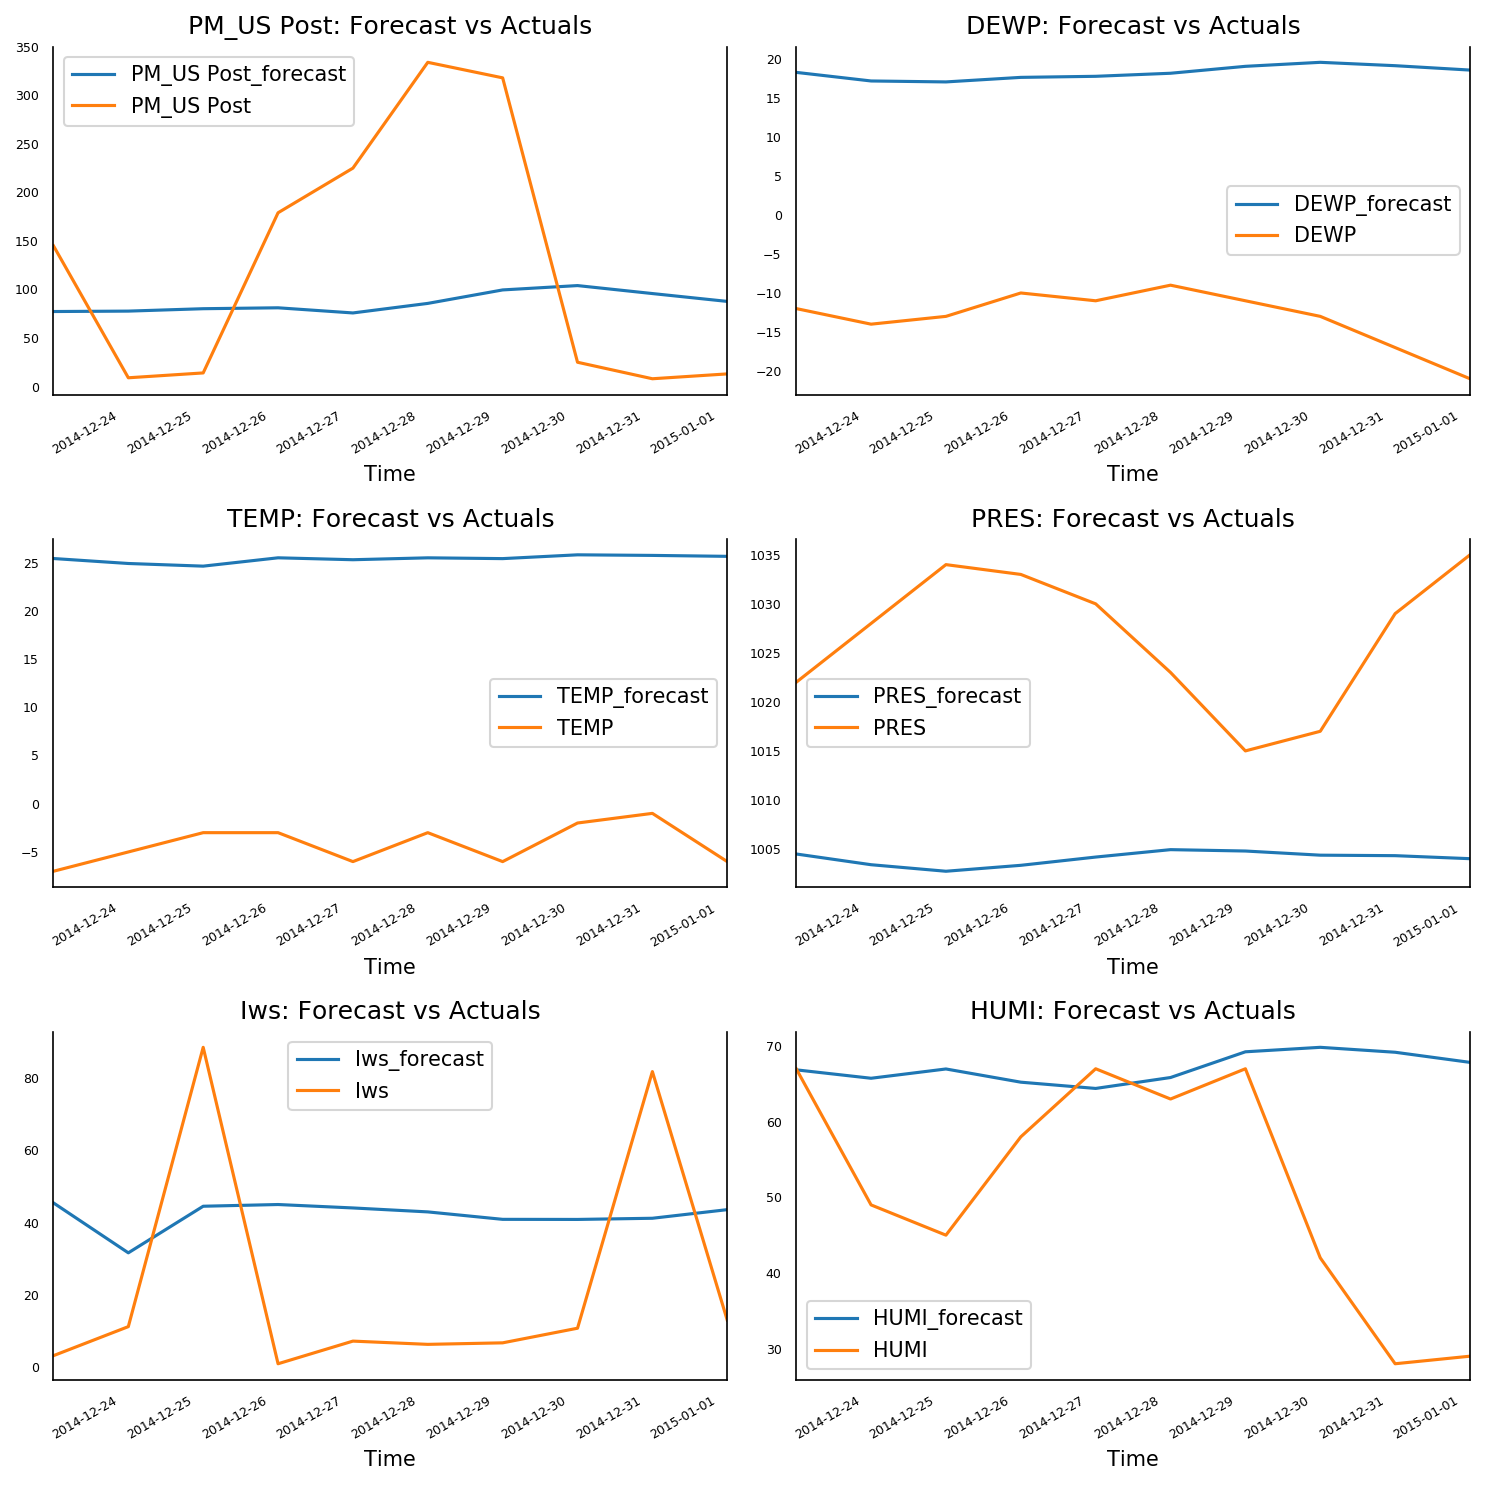

In [50]:
fig, axes = plt.subplots(nrows=int(len(dataset.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(dataset.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

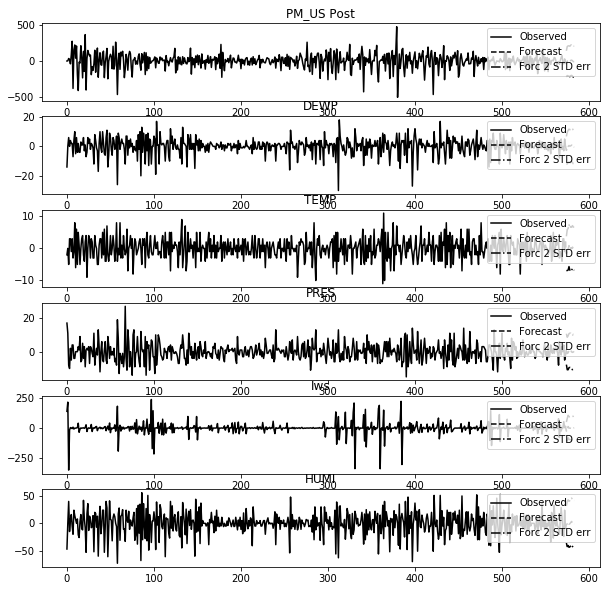

In [43]:
results.plot_forecast(10); #Cannot enlarge/change the figsize

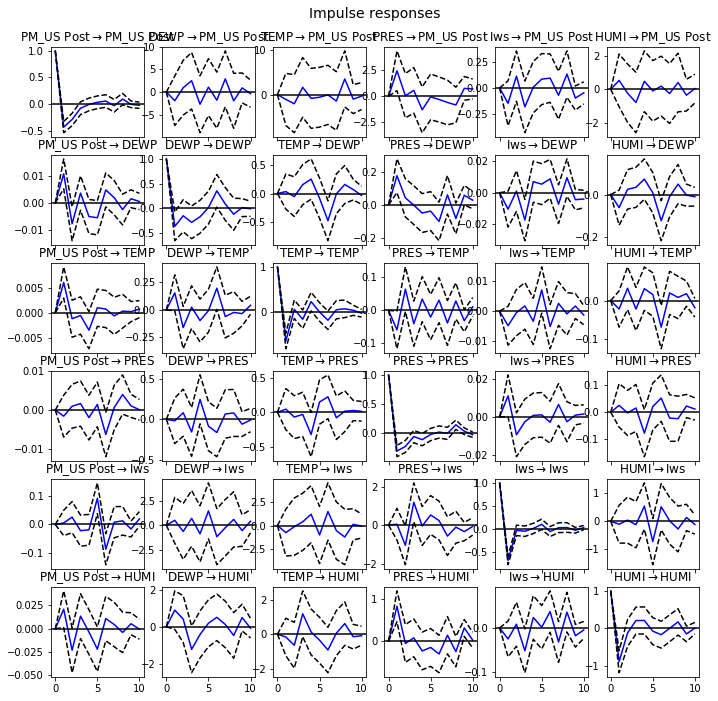

In [44]:
#impulse response analysis
irf = results.irf(10)
irf.plot(orth=False);

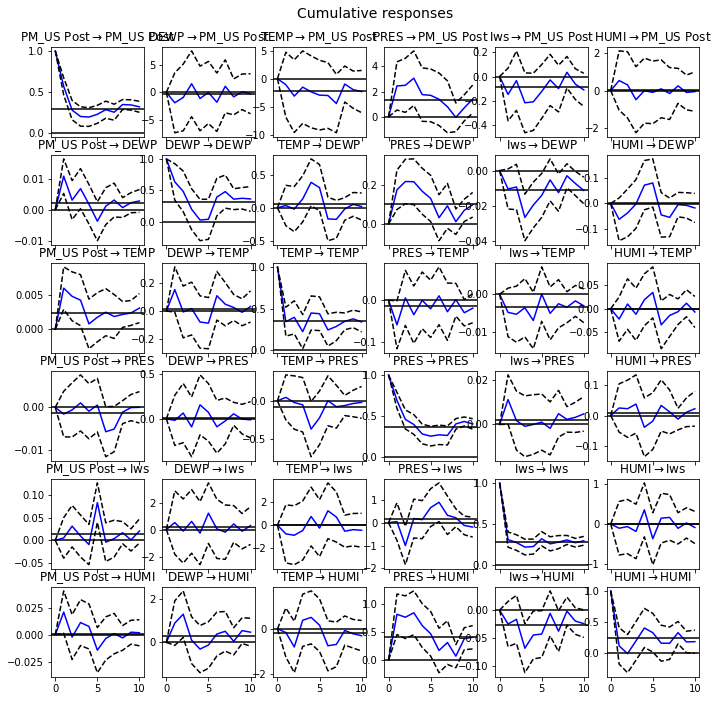

In [45]:
#impulse response analysis wiht cumulative effect
irf.plot_cum_effects(orth=False);

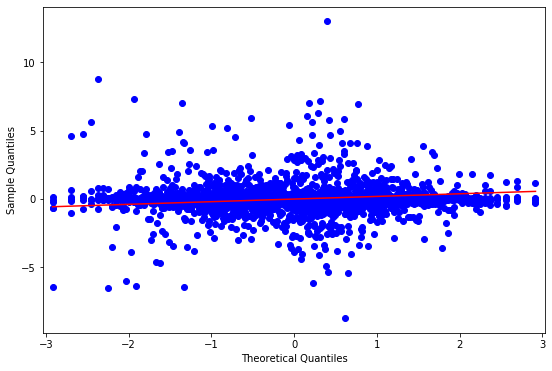

In [47]:
resid = results.resid
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

In [ ]:
#Forecast Error Variance Decomposition (FEVD) method
fevd = results.fevd(5)
fevd.summary()